In [1]:
"""
Created on Wed Jan 23 11:48:32 2019

@author: Andrew Welsh

This notebook is for doing model parameter tuning grid searches and feature selection using historical data, 
with intention of finding the optimal parameters to use for the live model fit. 

The data must be extracted via SQL prior to inclusion in this notebook (until a data connection directly to 
the database from Seth's machines is configured), then saved via CSV, which is read here. 

Intended use is for initial model development, as well as when new features are added.

Output: knowledge of optimal model parameters to attain best fit
"""

#import pypyodbc 
import pandas as pd
import churn_common as p #imports F2 score function, model_fit function

# imported data already has nulls cleaned and unused columns dropped
# churn_dedi_model_training_fit.csv is output from 'churn_dedi_model_training_fit.py' python script
dedicated = pd.read_csv('churn_dedi_model_training_fit.csv', encoding='ISO-8859-1')

print('Query complete')
pd.options.display.max_columns = None
#dedicated = dedicated.iloc[1:5000, :].copy() #select first 5k rows for fast testing
dedicated = dedicated.loc[dedicated['avg per line item invoiced in last 6 months_original'].notnull()] 


Query complete


In [3]:
#index column from CSV is imported as a separate column, labeled 'Unnamed: 0', therefore must be dropped before model fit
dedicated.drop(['Unnamed: 0'], axis=1, inplace=True)

#generate TMK date column
dedicated['time_month_key_dt']=pd.to_datetime(
        dedicated['time_month_key'].apply(str).str.slice(stop=4)+"-"+
        dedicated['time_month_key'].apply(str).str.slice(start=4)+"-01")

#hold out evaluation dataset of last 3 months
#Months are hard-coded here, use df['time_month_key'].max() to find max TMK, configure eval set to be 3 most recent months
#Example: max TMK 201812; eval data is 201810 to 201812 inclusive, dedicated_num is 201809 and earlier
#min TMK is 201507
#max TMK is 201809

#define model training dataset, set to TMK < max(TMK)-3
dedicated_train = dedicated.loc[dedicated['time_month_key']<201806]
dedicated_train.set_index(['account_number','time_month_key'])

#hold out evaluation dataset of last 3 months
dedicated_val = dedicated.loc[(dedicated['time_month_key']>=201806) & (dedicated['time_month_key']<201809)]
dedicated_val.set_index(['account_number','time_month_key'])

#the table head for the eval data should output below. Most accounts should have 3 rows each (3 latest TMKs).

average_invoiced_last_12_months  target  \
account_number time_month_key                                            
1000165        201806                              1542.530000       0   
               201807                              1542.530000       0   
               201808                              1542.530000       0   
1000171        201806                             56739.110000       0   
               201807                             56948.560833       0   
               201808                             57157.508333       0   
1000197        201806                              2265.760000       0   
               201807                              2265.760000       0   
               201808                              2265.760000       0   
1000403        201806                              3038.170000       0   
               201807                              2960.295000       0   
               201808                              2882.420000       0   
1000516        201806                             13791.928333       0   
               201807                             14221.305833       0   
               201808                             14639.621666       0   
1000740        201806                             34471.640833       0   
               201807                             33705.033333       0   
               201808                             32955.977500       0   
1000791        201806                             58594.003333       1   
               201807                             57328.259166       1   
               201808                             52527.990833       1   
1000806        201806                               997.315000       0   
               201807                               953.440000       0   
               201808                               909.565000       0   
1000815        201806                              1817.799166       0   
               201807                              1818.038333       0   
               201808                              1818.277500       0   
1001062        201806                               819.000000       0   
               201807                               819.000000       0   
               201808                               819.000000       0   
...                                                        ...     ...   
998749         201808                               581.486666       0   
998812         201806                             15545.117500       0   
               201807                             15558.491666       0   
               201808                             15539.404166       0   
998890         201806                              5783.793333       0   
               201807                              5812.655000       0   
               201808                              5829.820000       0   
998901         201806                              2839.930000       0   
               201807                              2839.930000       0   
               201808                              2839.930000       0   
998964         201806                             20236.613333       1   
               201807                             19597.575833       1   
               201808                             18958.538333       1   
999037         201806                              4244.699166       0   
               201807                              4649.928333       0   
               201808                              5113.604166       0   
999426         201806                               654.560833       0   
               201807                               639.243333       0   
               201808                               623.925833       0   
999821         201806                               655.000000       0   
               201807                               655.000000       1   
999839         201806              

In [4]:
#split datasets into low-med-hi revenue segments

#training dataset
dedicated_train_low, dedicated_train_mid, dedicated_train_hi = p.split_df_revenue_segments(dedicated_train, 'average_invoiced_last_12_months')

#validation dataset
dedicated_val_low, dedicated_val_mid, dedicated_val_hi = p.split_df_revenue_segments(dedicated_val, 'average_invoiced_last_12_months')

print("Train-test-eval split complete")

Train-test-eval split complete


In [5]:
#==================================================================================================================
#==================================================================================================================
# Resample minority class in training dataset
#==================================================================================================================
#==================================================================================================================

#for repeatable results, set seed equal to an integer; for random assignment, set seed to None
seed = 155

dedicated_train_low_rus = p.AndrewsRandomUnderSampler(dedicated_train_low, 'target', seed)
dedicated_train_mid_rus = p.AndrewsRandomUnderSampler(dedicated_train_mid, 'target', seed)
dedicated_train_hi_rus = p.AndrewsRandomUnderSampler(dedicated_train_hi, 'target', seed)

print('Minority class resampling complete')

Minority class resampling complete


In [6]:
#define lists of target (y) and predictor (x) columns
exclude_col = ['target'
               ,'average_invoiced_last_12_months'
               ,'account_number'
               ,'time_month_key'
               ,'month_order'
               ,'time_month_key_dt'
               ]


include_col_low = [
'3_mth_pct_change_longest_active_device_tenure_months'
,'3_mth_pct_change_number_of_device_status_eq_computer_no_longer_active'
,'3_mth_pct_change_number_of_devices_active_status_active'
,'3_mth_pct_change_number_of_devices_online_status_online'
,'acc_tenure_in_months'
,'account_sla_type_num'
,'annualrevenue_original'
,'average_active_device_tenure_months'
,'average_value_of_opportunities_last_3_months'
,'average_value_of_opportunities_last_6_months'
,'avg_credit_memo_in_last_6_months'
,'avg_mthly_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'avg_mthly_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'avg_mthly_num_of_invoiced_items_in_last_6_months'
,'avg_per_line_item_invoiced_in_last_6_months_original'
,'company_age_original'
,'how_many_units_bandwidth_overages'
,'how_many_units_cloud_block_storage'
,'how_many_units_dedicated_san'
,'how_many_units_firewall'
,'how_many_units_load_balancer'
,'how_many_units_managed_exchange'
,'how_many_units_managed_storage'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'how_many_units_san'
,'how_many_units_server'
,'how_many_units_switch'
,'how_many_units_threat_manager'
,'how_many_units_virtual_hosting'
,'how_many_units_virtualization'
,'last_survey_score'
,'longest_active_device_tenure_months'
,'num_distinct_account_bdc'
,'num_distinct_account_billing_city'
,'num_distinct_account_billing_country'
,'num_distinct_account_billing_postal_code'
,'num_distinct_account_billing_state'
,'num_distinct_account_billing_street'
,'num_distinct_account_business_type'
,'num_distinct_account_manager'
,'num_distinct_account_primary_contact'
,'num_opportunities_last_6_months'
,'num_opportunities_won_last_3_months'
,'num_opportunities_won_last_6_months'
,'num_opportunities'
,'num_opps_category_migration'
,'num_opps_support_unit_smb'
,'num_opps_typex_aws'
,'num_opps_typex_dedicated_private_cloud'
,'num_opps_typex_revenue_ticket'
,'number_of_device_status_eq_computer_no_longer_active'
,'number_of_device_status_eq_online_complete'
,'number_of_device_status_eq_support_maintenance'
,'number_of_devices_last_month'
,'number_of_devices_os_firewall'
,'number_of_devices_os_load_balancer'
,'number_of_devices_os_switch'
,'number_of_devices_os_name_linux'
,'number_of_other_device_status'
,'number_of_accounts_original'
,'number_of_cloud_accounts'
,'number_of_customer_accounts'
,'numberofemployees_original'
,'pct_of_device_status_eq_support_maintenance'
,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_devices_with_contract_status_eq_no_contract_status'
,'pct_of_devices_with_contract_status_eq_out_of_contract_mtm'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_cloud_block_storage'
,'pct_of_invoice_cloud_files'
,'pct_of_invoice_firewall'
,'pct_of_invoice_load_balancer'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rackspace_email'
,'pct_of_invoice_rpc_core'
,'pct_of_invoice_san'
,'pct_of_invoice_server'
,'pct_of_invoice_switch'
,'pct_of_invoice_threat_manager'
,'pct_of_invoice_virtual_hosting'
,'pct_of_invoice_virtualization'
,'pct_of_other_device_status'
,'pct_of_revenue_with_contract_status_in_contract_risk_of_lapse_90_days'
,'pct_of_revenue_with_contract_status_in_contract'
,'pct_of_revenue_with_contract_status_no_contract_status'
,'pct_of_revenue_with_contract_status_out_of_contract_mtm'
,'pct_opportunities_lost_last_3_months'
,'pct_opportunities_won_last_3_months'
,'pct_opportunities_won_last_6_months'
,'avg_unit_price_bandwidth_overages'
,'avg_unit_price_cloud_files'
,'avg_unit_price_dedicated_san'
,'avg_unit_price_firewall'
,'avg_unit_price_load_balancer'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_managed_storage'
,'avg_unit_price_next_gen_servers'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'avg_unit_price_san'
,'avg_unit_price_server'
,'avg_unit_price_switch'
,'avg_unit_price_threat_manager'
,'avg_unit_price_virtual_hosting'
,'avg_unit_price_virtualization'
,'second_last_survey_score'
,'shortest_active_device_tenure_months'
,'ratio_num_of_invoiced_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_in_last_6_months_vs_prior_6_months'
,'total_invoiced_in_last_6_months'
,'total_value_of_opportunities_last_6_months'
               ]

include_col_mid = [
'3_mth_pct_change_longest_active_device_tenure_months'
,'3_mth_pct_change_number_of_device_status_eq_computer_no_longer_active'
,'3_mth_pct_change_number_of_devices_active_status_active'
,'3_mth_pct_change_number_of_devices_online_status_online'
,'acc_tenure_in_months'
,'account_sla_type_num'
,'annualrevenue_original'
,'average_active_device_tenure_months'
,'average_value_of_opportunities_last_3_months'
,'average_value_of_opportunities_last_6_months'
,'avg_credit_memo_in_last_6_months'
,'avg_mthly_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'avg_mthly_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'avg_mthly_num_of_invoiced_items_in_last_6_months'
,'avg_per_line_item_invoiced_in_last_6_months_original'
,'company_age_original'
,'how_many_units_bandwidth_overages'
,'how_many_units_cloud_block_storage'
,'how_many_units_dedicated_san'
,'how_many_units_firewall'
,'how_many_units_load_balancer'
,'how_many_units_managed_exchange'
,'how_many_units_managed_storage'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'how_many_units_san'
,'how_many_units_server'
,'how_many_units_switch'
,'how_many_units_threat_manager'
,'how_many_units_virtual_hosting'
,'how_many_units_virtualization'
,'last_survey_score'
,'longest_active_device_tenure_months'
,'num_distinct_account_bdc'
,'num_distinct_account_billing_city'
,'num_distinct_account_billing_country'
,'num_distinct_account_billing_postal_code'
,'num_distinct_account_billing_state'
,'num_distinct_account_billing_street'
,'num_distinct_account_business_type'
,'num_distinct_account_manager'
,'num_distinct_account_primary_contact'
,'num_opportunities_last_6_months'
,'num_opportunities_won_last_3_months'
,'num_opportunities_won_last_6_months'
,'num_opportunities'
,'num_opps_category_migration'
,'num_opps_support_unit_smb'
,'num_opps_typex_aws'
,'num_opps_typex_dedicated_private_cloud'
,'num_opps_typex_revenue_ticket'
,'number_of_device_status_eq_computer_no_longer_active'
,'number_of_device_status_eq_online_complete'
,'number_of_device_status_eq_support_maintenance'
,'number_of_devices_last_month'
,'number_of_devices_os_firewall'
,'number_of_devices_os_load_balancer'
,'number_of_devices_os_switch'
,'number_of_devices_os_name_linux'
,'number_of_other_device_status'
,'number_of_accounts_original'
,'number_of_cloud_accounts'
,'number_of_customer_accounts'
,'numberofemployees_original'
,'pct_of_device_status_eq_support_maintenance'
,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_devices_with_contract_status_eq_no_contract_status'
,'pct_of_devices_with_contract_status_eq_out_of_contract_mtm'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_cloud_block_storage'
,'pct_of_invoice_cloud_files'
,'pct_of_invoice_firewall'
,'pct_of_invoice_load_balancer'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rackspace_email'
,'pct_of_invoice_rpc_core'
,'pct_of_invoice_san'
,'pct_of_invoice_server'
,'pct_of_invoice_switch'
,'pct_of_invoice_threat_manager'
,'pct_of_invoice_virtual_hosting'
,'pct_of_invoice_virtualization'
,'pct_of_other_device_status'
,'pct_of_revenue_with_contract_status_in_contract_risk_of_lapse_90_days'
,'pct_of_revenue_with_contract_status_in_contract'
,'pct_of_revenue_with_contract_status_no_contract_status'
,'pct_of_revenue_with_contract_status_out_of_contract_mtm'
,'pct_opportunities_lost_last_3_months'
,'pct_opportunities_won_last_3_months'
,'pct_opportunities_won_last_6_months'
,'avg_unit_price_bandwidth_overages'
,'avg_unit_price_cloud_files'
,'avg_unit_price_dedicated_san'
,'avg_unit_price_firewall'
,'avg_unit_price_load_balancer'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_managed_storage'
,'avg_unit_price_next_gen_servers'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'avg_unit_price_san'
,'avg_unit_price_server'
,'avg_unit_price_switch'
,'avg_unit_price_threat_manager'
,'avg_unit_price_virtual_hosting'
,'avg_unit_price_virtualization'
,'second_last_survey_score'
,'shortest_active_device_tenure_months'
,'ratio_num_of_invoiced_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_in_last_6_months_vs_prior_6_months'
,'total_invoiced_in_last_6_months'
,'total_value_of_opportunities_last_6_months'
]

include_col_hi = [
'3_mth_pct_change_longest_active_device_tenure_months'
,'3_mth_pct_change_number_of_device_status_eq_computer_no_longer_active'
,'3_mth_pct_change_number_of_devices_active_status_active'
,'3_mth_pct_change_number_of_devices_online_status_online'
,'acc_tenure_in_months'
,'account_sla_type_num'
,'annualrevenue_original'
,'average_active_device_tenure_months'
,'average_value_of_opportunities_last_3_months'
,'average_value_of_opportunities_last_6_months'
,'avg_credit_memo_in_last_6_months'
,'avg_mthly_num_of_invoiced_items_in_last_3_months_vs_prior_3_months'
,'avg_mthly_num_of_invoiced_items_in_last_6_months_vs_prior_6_months'
,'avg_mthly_num_of_invoiced_items_in_last_6_months'
,'avg_per_line_item_invoiced_in_last_6_months_original'
,'company_age_original'
,'how_many_units_bandwidth_overages'
,'how_many_units_cloud_block_storage'
,'how_many_units_dedicated_san'
,'how_many_units_firewall'
,'how_many_units_load_balancer'
,'how_many_units_managed_exchange'
,'how_many_units_managed_storage'
,'how_many_units_rackspace_email'
,'how_many_units_rpc_core'
,'how_many_units_san'
,'how_many_units_server'
,'how_many_units_switch'
,'how_many_units_threat_manager'
,'how_many_units_virtual_hosting'
,'how_many_units_virtualization'
,'last_survey_score'
,'longest_active_device_tenure_months'
,'num_distinct_account_bdc'
,'num_distinct_account_billing_city'
,'num_distinct_account_billing_country'
,'num_distinct_account_billing_postal_code'
,'num_distinct_account_billing_state'
,'num_distinct_account_billing_street'
,'num_distinct_account_business_type'
,'num_distinct_account_manager'
,'num_distinct_account_primary_contact'
,'num_opportunities_last_6_months'
,'num_opportunities_won_last_3_months'
,'num_opportunities_won_last_6_months'
,'num_opportunities'
,'num_opps_category_migration'
,'num_opps_support_unit_smb'
,'num_opps_typex_aws'
,'num_opps_typex_dedicated_private_cloud'
,'num_opps_typex_revenue_ticket'
,'number_of_device_status_eq_computer_no_longer_active'
,'number_of_device_status_eq_online_complete'
,'number_of_device_status_eq_support_maintenance'
,'number_of_devices_last_month'
,'number_of_devices_os_firewall'
,'number_of_devices_os_load_balancer'
,'number_of_devices_os_switch'
,'number_of_devices_os_name_linux'
,'number_of_other_device_status'
,'number_of_accounts_original'
,'number_of_cloud_accounts'
,'number_of_customer_accounts'
,'numberofemployees_original'
,'pct_of_device_status_eq_support_maintenance'
,'pct_of_devices_with_contract_status_eq_in_contract'
,'pct_of_devices_with_contract_status_eq_no_contract_status'
,'pct_of_devices_with_contract_status_eq_out_of_contract_mtm'
,'pct_of_invoice_bandwidth_overages'
,'pct_of_invoice_cloud_block_storage'
,'pct_of_invoice_cloud_files'
,'pct_of_invoice_firewall'
,'pct_of_invoice_load_balancer'
,'pct_of_invoice_managed_exchange'
,'pct_of_invoice_managed_storage'
,'pct_of_invoice_rackspace_email'
,'pct_of_invoice_rpc_core'
,'pct_of_invoice_san'
,'pct_of_invoice_server'
,'pct_of_invoice_switch'
,'pct_of_invoice_threat_manager'
,'pct_of_invoice_virtual_hosting'
,'pct_of_invoice_virtualization'
,'pct_of_other_device_status'
,'pct_of_revenue_with_contract_status_in_contract_risk_of_lapse_90_days'
,'pct_of_revenue_with_contract_status_in_contract'
,'pct_of_revenue_with_contract_status_no_contract_status'
,'pct_of_revenue_with_contract_status_out_of_contract_mtm'
,'pct_opportunities_lost_last_3_months'
,'pct_opportunities_won_last_3_months'
,'pct_opportunities_won_last_6_months'
,'avg_unit_price_bandwidth_overages'
,'avg_unit_price_cloud_files'
,'avg_unit_price_dedicated_san'
,'avg_unit_price_firewall'
,'avg_unit_price_load_balancer'
,'avg_unit_price_managed_exchange'
,'avg_unit_price_managed_storage'
,'avg_unit_price_next_gen_servers'
,'avg_unit_price_rackspace_email'
,'avg_unit_price_rpc_core'
,'avg_unit_price_san'
,'avg_unit_price_server'
,'avg_unit_price_switch'
,'avg_unit_price_threat_manager'
,'avg_unit_price_virtual_hosting'
,'avg_unit_price_virtualization'
,'second_last_survey_score'
,'shortest_active_device_tenure_months'
,'ratio_num_of_invoiced_in_last_3_months_vs_prior_3_months'
,'ratio_num_of_invoiced_in_last_6_months_vs_prior_6_months'
,'total_invoiced_in_last_6_months'
,'total_value_of_opportunities_last_6_months'
]

#predictors = list(dedicated_train.columns[~dedicated_train.columns.isin(exclude_col)])
#predictors = list(dedicated_train.columns[dedicated_train.columns.isin(include_col)])
predictors_low = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_low)])
predictors_mid = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_mid)])
predictors_hi = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_hi)])


#create copy of the X and Y columns
x1_train_res_low = dedicated_train_low_rus[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_train_res_low = dedicated_train_low_rus['target']

x1_train_res_mid = dedicated_train_mid_rus[predictors_mid]
y1_train_res_mid = dedicated_train_mid_rus['target']

x1_train_res_hi = dedicated_train_hi_rus[predictors_hi]
y1_train_res_hi = dedicated_train_hi_rus['target']

print("train ready")

#create copy of the X and Y columns for validation data
x_val_low = dedicated_val_low[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_val_low = dedicated_val_low['target']

x_val_mid = dedicated_val_mid[predictors_mid]
y1_val_mid = dedicated_val_mid['target']

x_val_hi = dedicated_val_hi[predictors_hi]
y1_val_hi = dedicated_val_hi['target']

print("eval ready")

train ready
eval ready


In [12]:
#Create time series split cross validators, cross-validated by time month key, on training dataset (test data generated 
#within the cross-validator routine, and used for grid search scoring in GridSearchCV API)
cvsplits = 4
cv_low = p.TimeSeriesSplitTMK(n_splits=cvsplits).split(dedicated_train_low_rus)
cv_mid = p.TimeSeriesSplitTMK(n_splits=cvsplits).split(dedicated_train_mid_rus)
cv_hi = p.TimeSeriesSplitTMK(n_splits=cvsplits).split(dedicated_train_hi_rus)

In [8]:
#import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import make_scorer, fbeta_score, matthews_corrcoef
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import time
import datetime
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [ ]:
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================
#Initial model run with no parameters tuned
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================

xgb_final_low = XGBClassifier(
        learning_rate=0.05, 
        n_estimators=1100, 
        max_depth=13, 
        max_features=13, 
        subsample=0.7,
        min_child_weight=1,
        gamma=0, 
        colsample_bytree=0.7, 
        scale_pos_weight=1, 
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=seed, 
        eval_metric='auc',
        objective='binary:logistic',
        nthread=128
        )

xgb_final_mid = XGBClassifier(
        learning_rate=0.05, 
        n_estimators=1300, 
        max_depth=9, 
        max_features=13, 
        subsample=0.7,
        min_child_weight=1,
        gamma=0, 
        colsample_bytree=0.7, 
        scale_pos_weight=1, 
        reg_alpha=1e-05,
        reg_lambda=0.01,
        random_state=seed, 
        eval_metric='auc',
        objective='binary:logistic',
        nthread=128
        )

xgb_final_hi = XGBClassifier(
        learning_rate=0.05, 
        n_estimators=1300, 
        max_depth=9, 
        max_features=13, 
        subsample=0.7,
        min_child_weight=1,
        gamma=0, 
        colsample_bytree=0.7, 
        scale_pos_weight=1, 
        reg_alpha=1e-05,
        reg_lambda=1,
        random_state=seed, 
        eval_metric='auc',
        objective='binary:logistic',
        nthread=128
        )

p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), x_val_low, y1_val_low, predictors)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), x_val_mid, y1_val_mid, predictors)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(), x_val_hi, y1_val_hi, predictors)

In [9]:
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================
#PARAMETER TUNING
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================

#defining the grid search metric scorer. Using F2 scores; this weighs the recall twice as much as the precision
f2_scorer = make_scorer(fbeta_score, beta=2)

#Using F0.5 scores weighs the precision twice as much as the recall
#f05_scorer = make_scorer(fbeta_score, beta=0.5)

#mcc = make_scorer(matthews_corrcoef)

In [14]:
print('Run first grid search for parameter tuning for low revenue accts')

#
#
#
#Tune learning rate, gamma and number of estimators
#
#
#

param_test1 = {
  'learning_rate':[0.005,0.01,0.02],#test values of 0.05 to 0.3. must be between 0 and 1
#  'gamma':[i/2 for i in range(0,2)], #test values of 0 to 3, in steps of 0.5. must be non-negative, default 0
#  'gamma':[0,5,10], #test values of 1, 5 and 10. default is 0, but overfitting is a problem
  'n_estimators':range(1500,2001,500) #test values of 500 to 1500, in steps of 500
}

start_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

g1_low = GridSearchCV(estimator = XGBClassifier(
#        learning_rate=0.1, 
#        n_estimators=500, 
        max_depth=13, 
        max_features=13, 
        subsample=0.8,
        min_child_weight=1,
#        gamma=0, 
        colsample_bytree=0.7, 
        scale_pos_weight=1, 
        reg_alpha=0.1,
        reg_lambda=1e-05,
        random_state=seed, 
        eval_metric='auc',
        objective='binary:logistic', #try binary:hinge?
        max_delta_step=0,
        nthread=-1), param_grid = param_test1, scoring=f2_scorer, n_jobs=-1,iid=False, cv=cv_low
                     )
#1st iteration {'gamma': 1, 'learning_rate': 0.01, 'n_estimators': 1250}

g1_mid = GridSearchCV(estimator = XGBClassifier(
#        learning_rate=0.1, 
#        n_estimators=500, 
        max_depth=13, 
        max_features=13, 
        subsample=0.8,
        min_child_weight=1,
#        gamma=0, 
        colsample_bytree=0.7, 
        scale_pos_weight=1, 
        reg_alpha=0.1,
        reg_lambda=1e-05,
        random_state=seed, 
        eval_metric='auc',
        objective='binary:logistic',
        max_delta_step=0,
        nthread=-1), param_grid = param_test1, scoring=f2_scorer, n_jobs=-1,iid=False, cv=cv_mid
                     )
#1st iteration {'gamma': 1, 'learning_rate': 0.005, 'n_estimators': 1000}

g1_hi = GridSearchCV(estimator = XGBClassifier(
        learning_rate=0.1, 
        n_estimators=1500, 
        max_depth=13, 
        max_features=13, 
        subsample=0.8,
        min_child_weight=1,
        gamma=0, 
        colsample_bytree=0.7, 
        scale_pos_weight=1, 
        reg_alpha=0.1,
        reg_lambda=1e-05,
        random_state=seed, 
        eval_metric='auc',
        objective='binary:logistic',
        max_delta_step=0,
        nthread=-1), param_grid = param_test1, scoring=f2_scorer, n_jobs=-1,iid=False, cv=cv_hi
                     )
#1st iteration {'gamma': 0, 'learning_rate': 0.005, 'n_estimators': 1500 (tested 1000-1500)}
#2nd iteration {'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 1500 (tested 1500-2000)}

#g1_low.fit(x1_train_res_low,y1_train_res_low)
#g1_mid.fit(x1_train_res_mid,y1_train_res_mid)
g1_hi.fit(x1_train_res_hi,y1_train_res_hi)


end_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

Run first grid search for parameter tuning for low revenue accts


In [15]:
#g1_low_params = g1_low.best_estimator_
#g1_mid_params = g1_mid.best_estimator_
#g1_hi_params = g1_hi.best_estimator_

#print(g1_low.best_estimator_)
#print(g1_low.best_params_)
#print(g1_low.best_score_)

#print(g1_mid.best_estimator_)
#print(g1_mid.best_params_)
#print(g1_mid.best_score_)

print(g1_hi.best_estimator_)
print(g1_hi.best_params_)
print(g1_hi.best_score_)

print(start_time)
print(end_time)

#print(g1_low.cv_results_)
#print(g1_mid.cv_results_)
print(g1_hi.cv_results_)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='auc', gamma=0,
       learning_rate=0.005, max_delta_step=0, max_depth=13,
       max_features=13, min_child_weight=1, missing=None,
       n_estimators=1500, n_jobs=1, nthread=-1,
       objective='binary:logistic', random_state=155, reg_alpha=0.1,
       reg_lambda=1e-05, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)
{'learning_rate': 0.005, 'n_estimators': 1500}
0.7397139508574285
2019-09-05 16:23:25
2019-09-05 18:54:48
{'mean_fit_time': array([8289.53292787, 8658.03089863, 7181.42434233, 7741.92829657,
       5575.35512137, 6234.82999021]), 'std_fit_time': array([ 722.27722947,  505.71633581, 1028.9689014 ,  916.0740689 ,
       1035.45512009, 1062.66003964]), 'mean_score_time': array([0.08562481, 0.07283765, 0.15812528, 0.12501335, 0.15894604,
       0.18485808]), 'std_score_time': array([0.04885133, 0.05725928, 0.04649319, 0.06427437, 0.00824604,
    

In [16]:
print('Run first grid search for parameter tuning for low and mid revenue accts')

g1_low.fit(x1_train_res_low,y1_train_res_low)
g1_mid.fit(x1_train_res_mid,y1_train_res_mid)
#g1_hi.fit(x1_train_res_hi,y1_train_res_hi)


end_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

Run first grid search for parameter tuning for low and mid revenue accts


In [17]:
g1_low_params = g1_low.best_estimator_
g1_mid_params = g1_mid.best_estimator_
g1_hi_params = g1_hi.best_estimator_

print(g1_low.best_estimator_)
print(g1_low.best_params_)
print(g1_low.best_score_)

print(g1_mid.best_estimator_)
print(g1_mid.best_params_)
print(g1_mid.best_score_)

print(g1_hi.best_estimator_)
print(g1_hi.best_params_)
print(g1_hi.best_score_)

print(start_time)
print(end_time)

print(g1_low.cv_results_)
print(g1_mid.cv_results_)
print(g1_hi.cv_results_)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='auc', gamma=0,
       learning_rate=0.02, max_delta_step=0, max_depth=13, max_features=13,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=155,
       reg_alpha=0.1, reg_lambda=1e-05, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'learning_rate': 0.02, 'n_estimators': 2000}
0.7276370800665357
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='auc', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=13, max_features=13,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=155,
       reg_alpha=0.1, reg_lambda=1e-05, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'learning_rate': 0.01, 'n_estimators': 2000}
0

(low revenue)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='auc', gamma=0.0,
       learning_rate=0.1, max_delta_step=0, max_depth=13, max_features=13,
       min_child_weight=1, missing=None, n_estimators=1400, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=15,
       reg_alpha=0.1, reg_lambda=1e-05, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [ ]:
Low:
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='auc', gamma=0,
       learning_rate=0.005, max_delta_step=0, max_depth=13,
       max_features=13, min_child_weight=1, missing=None,
       n_estimators=1750, n_jobs=1, nthread=-1,
       objective='binary:logistic', random_state=17, reg_alpha=0.1,
       reg_lambda=1e-05, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)
{'learning_rate': 0.005, 'n_estimators': 1750}
0.7607220178419795
Mid: 
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='auc', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=13, max_features=13,
       min_child_weight=1, missing=None, n_estimators=1500, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=17,
       reg_alpha=0.1, reg_lambda=1e-05, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
{'learning_rate': 0.01, 'n_estimators': 1500}
0.7877350749486776

In [ ]:
#
#
#
#
#Tune max_delta_step, max_depth and min_child_weight
#
#XGBoost docs say "Maximum delta step we allow each leaf output to be. If the value is set 
#to 0, it means there is no constraint. If it is set to a positive value, it can help making 
#the update step more conservative. Usually this parameter is not needed, but it might help 
#in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might 
#help control the update." 
#
#max_delta_step range is 0 to infinity
#
#
#
#

param_test2 = {
 'max_depth':range(11,16,2)
 ,'min_child_weight':range(1,3,1)
 ,'max_delta_step':range(0,3,1) #try values 0 through 2, increment by 1
}

#Create time series split cross validators, cross-validated by time month key, on training dataset (test data generated 
#within the cross-validator routine, and used for grid search scoring in GridSearchCV API)
cvsplits = 3
cv_low = p.TimeSeriesSplitTMK(n_splits=cvsplits).split(dedicated_train_low_rus)
cv_mid = p.TimeSeriesSplitTMK(n_splits=cvsplits).split(dedicated_train_mid_rus)
cv_hi = p.TimeSeriesSplitTMK(n_splits=cvsplits).split(dedicated_train_hi_rus)

start_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

#g2_low = GridSearchCV(estimator = XGBClassifier(g1_low_params), param_grid = param_test2, scoring=f2_scorer
#                      ,n_jobs=-1,iid=False, cv=3)


#g2_mid = GridSearchCV(estimator = XGBClassifier(g1_mid_params), param_grid = param_test2, scoring=f2_scorer
#                      ,n_jobs=-1,iid=False, cv=3)

#g2_hi = GridSearchCV(estimator = XGBClassifier(g1_hi_params), param_grid = param_test2, scoring=f2_scorer
#                     ,n_jobs=-1,iid=False, cv=3)

g2_low = GridSearchCV(estimator = XGBClassifier(
#{'learning_rate': 0.005, 'n_estimators': 1750}
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bytree=0.7,
        gamma=10, 
        learning_rate=0.0001,
#        max_delta_step=1, 
#        max_depth=15, 
#        min_child_weight=1, 
        missing=None,
        n_estimators=1500, 
        random_state=seed,
        reg_alpha=0.1,
        reg_lambda=1e-05,
        scale_pos_weight=1,
        silent=True,
        subsample=0.8,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1), param_grid = param_test2, scoring=f05_scorer
                      ,n_jobs=-1,iid=False, cv=cv_low)

g2_mid = GridSearchCV(estimator = XGBClassifier(
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bytree=0.9,
        gamma=1, 
        learning_rate=0.01,
#        max_delta_step=1, 
#        max_depth=15, 
#        min_child_weight=1, 
        missing=None,
        n_estimators=1500, 
        random_state=seed,
        reg_alpha=0.01,
        reg_lambda=0.1,
        scale_pos_weight=1,
        silent=True,
        subsample=0.7,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1), param_grid = param_test2, scoring=f05_scorer
                      ,n_jobs=-1,iid=False, cv=cv_mid)
#1st iteration: {'max_delta_step': 1, 'max_depth': 11, 'min_child_weight': 1}

g2_hi = GridSearchCV(estimator = XGBClassifier(
        learning_rate=0.01, 
        n_estimators=1500, 
        max_depth=13, 
        max_features=13, 
        subsample=0.8,
        min_child_weight=1,
        gamma=0, 
        colsample_bytree=0.7, 
        scale_pos_weight=1, 
        reg_alpha=0.1,
        reg_lambda=1e-05,
        random_state=seed, 
        eval_metric='auc',
        objective='binary:logistic',
        max_delta_step=0,
        nthread=-1), param_grid = param_test2, scoring=f05_scorer, n_jobs=-1,iid=False, cv=cv_hi)
#1st iteration {'max_delta_step': 1, 'max_depth': 11, 'min_child_weight': 1}

g2_low.fit(x1_train_res_low,y1_train_res_low)
g2_mid.fit(x1_train_res_mid,y1_train_res_mid)
g2_hi.fit(x1_train_res_hi,y1_train_res_hi)

end_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
#g2_low_params = g2_low.best_estimator_
#g2_mid_params = g2_mid.best_estimator_
g2_hi_params = g2_hi.best_estimator_

#print(g2_low.best_estimator_)
#print(g2_low.best_params_)
#print(g2_low.best_score_)

#print(g2_mid.best_estimator_)
#print(g2_mid.best_params_)
#print(g2_mid.best_score_)

print(g2_hi.best_estimator_)
print(g2_hi.best_params_)
print(g2_hi.best_score_)

print(start_time)
print(end_time)

#print(g2_low.cv_results_)
#print(g2_mid.cv_results_)
print(g2_hi.cv_results_)


In [ ]:
#
#
#
#
#Tune Subsample and colsample_bytree
#
#
#
#
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)], #test values of 0.0 to 0.4, in steps of 0.1
 'subsample':[i/10.0 for i in range(7,11)], #test values of 0.7 to 1.0, in steps of 0.1
 'colsample_bytree':[0.7,0.8,0.9,1]
}

start_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

#g3_low = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=1,
#       max_depth=19, min_child_weight=1, missing=None, n_estimators=2400,
#       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
#       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#       silent=True, subsample=1), param_grid = param_test3, scoring=f2_scorer
#                      ,n_jobs=-1,iid=False, cv=3)


g3_mid = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=1,
       max_depth=15, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1), param_grid = param_test3, scoring=f2_scorer
                      ,n_jobs=-1,iid=False, cv=2)


g3_hi = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=21, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1), param_grid = param_test3, scoring=f2_scorer
                     ,n_jobs=-1,iid=False, cv=2)

#g3_low.fit(x1_train_res_low,y1_train_res_low)
g3_mid.fit(x1_train_res_mid,y1_train_res_mid)
g3_hi.fit(x1_train_res_hi,y1_train_res_hi)

end_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
#g3_low_params = g3_low.best_estimator_
g3_mid_params = g3_mid.best_estimator_
g3_hi_params = g3_hi.best_estimator_

#print(g3_low.cv_results_)
#print(g3_low.best_estimator_)
#print(g3_low.best_params_)
#print(g3_low.best_score_)

#print(g3_mid.cv_results_)
print(g3_mid.best_estimator_)
print(g3_mid.best_params_)
print(g3_mid.best_score_)

#print(g3_hi.cv_results_)
print(g3_hi.best_estimator_)
print(g3_hi.best_params_)
print(g3_hi.best_score_)

print(start_time)
print(end_time)

In [ ]:
#
#
#
#
#Tune Regularization alpha (L1)
# and lambda (L2)
#
#
#
#
param_test4 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 10, 50, 100]
}

start_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

#g4_low = GridSearchCV(estimator = XGBClassifier(g3_low_params), param_grid = param_test4, scoring=f2_scorer
#                      ,n_jobs=-1,iid=False, cv=2)


g4_mid = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=1, max_depth=15, min_child_weight=1, missing=None,
       n_estimators=2000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7), param_grid = param_test4, scoring=f2_scorer
                      ,n_jobs=-1,iid=False, cv=2)


g4_hi = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
       n_estimators=2000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7), param_grid = param_test4, scoring=f2_scorer
                     ,n_jobs=-1,iid=False, cv=2)

#g4_low.fit(x1_train_res_low,y1_train_res_low)
g4_mid.fit(x1_train_res_mid,y1_train_res_mid)
g4_hi.fit(x1_train_res_hi,y1_train_res_hi)

end_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
#g4_low_params = g4_low.best_estimator_
g4_mid_params = g4_mid.best_estimator_
g4_hi_params = g4_hi.best_estimator_

#print(g4_low.cv_results_)
#print(g4_low.best_estimator_)
#print(g4_low.best_params_)
#print(g4_low.best_score_)

#print(g4_mid.cv_results_)
print(g4_mid.best_estimator_)
print(g4_mid.best_params_)
print(g4_mid.best_score_)

#print(g4_hi.cv_results_)
print(g4_hi.best_estimator_)
print(g4_hi.best_params_)
print(g4_hi.best_score_)

print(start_time)
print(end_time)

In [ ]:
#
#
#
#
#Tune learning rate and n_estimators
#
#
#
#
param_test5 = {
 'max_delta_step': range(0,6,1)
}

start_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

g5_low = GridSearchCV(estimator = XGBClassifier(g4_low_params), param_grid = param_test5, scoring=f2_scorer
                      ,n_jobs=-1,iid=False, cv=2)


g5_mid = GridSearchCV(estimator = XGBClassifier(g4_mid_params), param_grid = param_test5, scoring=f2_scorer
                      ,n_jobs=-1,iid=False, cv=2)


g5_hi = GridSearchCV(estimator = XGBClassifier(g4_hi_params), param_grid = param_test5, scoring=f2_scorer
                     ,n_jobs=-1,iid=False, cv=2)

g5_low.fit(x1_train_res_low,y1_train_res_low)
g5_mid.fit(x1_train_res_mid,y1_train_res_mid)
g5_hi.fit(x1_train_res_hi,y1_train_res_hi)

end_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
g5_low_params = g5_low.best_estimator_
g5_mid_params = g5_mid.best_estimator_
g5_hi_params = g5_hi.best_estimator_

#print(g5_low.cv_results_)
print(g5_low.best_estimator_)
print(g5_low.best_params_)
print(g5_low.best_score_)

#print(g5_mid.cv_results_)
print(g5_mid.best_estimator_)
print(g5_mid.best_params_)
print(g5_mid.best_score_)

#print(g5_hi.cv_results_)
print(g5_hi.best_estimator_)
print(g5_hi.best_params_)
print(g5_hi.best_score_)

print(start_time)
print(end_time)


Model Fit Start time
2019-09-16 16:54:23




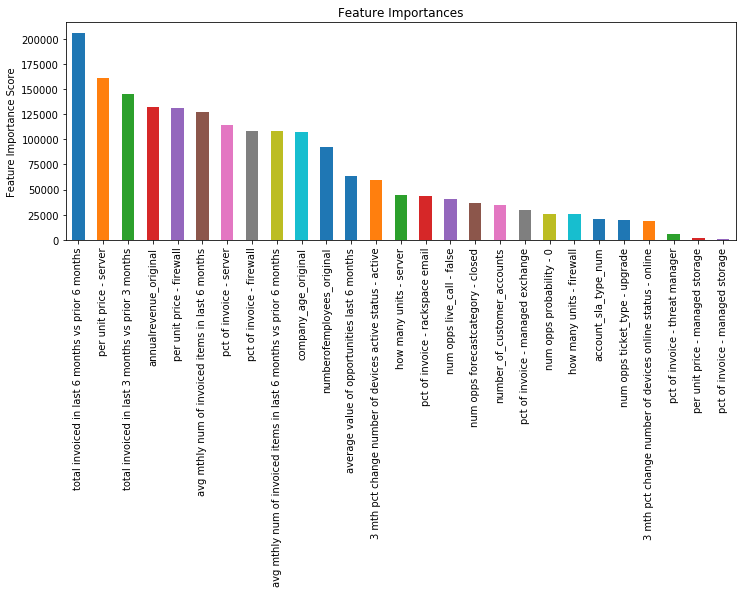

total invoiced in last 6 months vs prior 6 months    206153
per unit price - server                              161334
total invoiced in last 3 months vs prior 3 months    145318
annualrevenue_original                               132051
per unit price - firewall                            131266
dtype: int64
Confusion matrix for evaluation data:
 [[19432   971]
 [  866  1499]]
Precision-Specificity 
 0.6068825910931174
Recall-Sensitivity 
 0.6338266384778013
F 2 Score 
 0.6282481139983235



Model Fit End time
2019-09-16 17:01:42

Model Fit Start time
2019-09-16 17:01:42




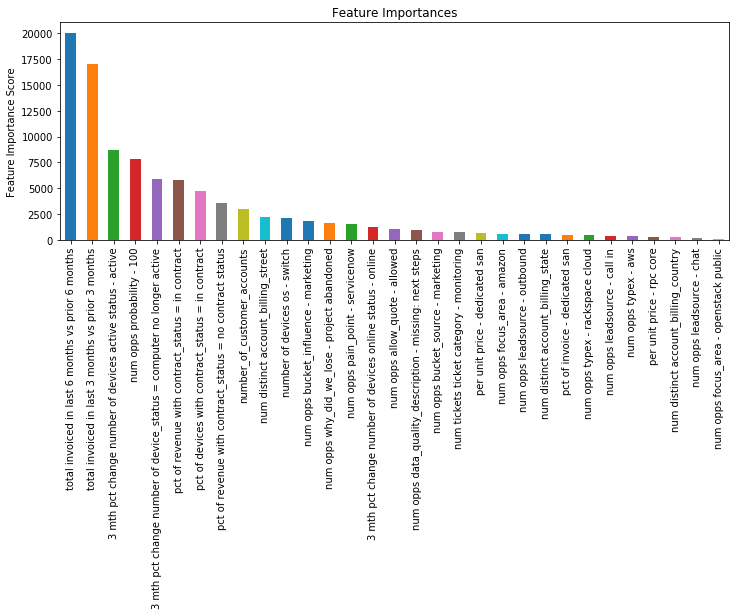

total invoiced in last 6 months vs prior 6 months                       20049
total invoiced in last 3 months vs prior 3 months                       17045
3 mth pct change number of devices active status - active                8683
num opps probability - 100                                               7855
3 mth pct change number of device_status = computer no longer active     5900
dtype: int64
Confusion matrix for evaluation data:
 [[5222  523]
 [ 305  637]]
Precision-Specificity 
 0.5491379310344827
Recall-Sensitivity 
 0.6762208067940552
F 2 Score 
 0.6463068181818182



Model Fit End time
2019-09-16 17:02:43

Model Fit Start time
2019-09-16 17:02:43




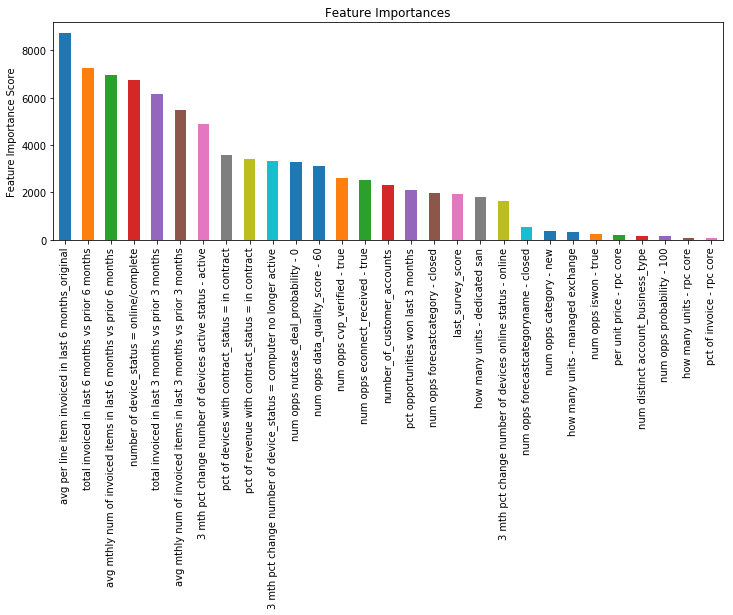

avg per line item invoiced in last 6 months_original                  8746
total invoiced in last 6 months vs prior 6 months                     7272
avg mthly num of invoiced items in last 6 months vs prior 6 months    6965
number of device_status = online/complete                             6738
total invoiced in last 3 months vs prior 3 months                     6168
dtype: int64
Confusion matrix for evaluation data:
 [[1650  231]
 [  84  223]]
Precision-Specificity 
 0.4911894273127753
Recall-Sensitivity 
 0.7263843648208469
F 2 Score 
 0.6629013079667063



Model Fit End time
2019-09-16 17:03:29


In [10]:
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================
#Final Model
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================

xgb_final_low = XGBClassifier(
        colsample_bylevel=1,
        colsample_bytree=0.7,
        gamma=0, 
        learning_rate=0.005,
        max_delta_step=2, 
        max_depth=14, 
        max_features=13, 
        min_child_weight=0, 
        n_estimators=1750, 
#        random_state=seed,
        reg_alpha=0.1,
        reg_lambda=1e-05,
        scale_pos_weight=1,
        silent=True,
        subsample=0.8,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1)

xgb_final_mid = XGBClassifier(
        colsample_bylevel=1,
        colsample_bytree=0.9,
        gamma=1, 
        learning_rate=0.01,
        max_delta_step=1, 
        max_depth=11, 
        min_child_weight=1, 
        missing=None,
        n_estimators=1500, 
#        random_state=seed,
        reg_alpha=0.01,
        reg_lambda=0.1,
        scale_pos_weight=1,
        silent=True,
        subsample=0.7,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1)


xgb_final_hi = XGBClassifier(
        colsample_bylevel=1,
        colsample_bytree=0.7,
        gamma=1, 
        learning_rate=0.01,
        max_delta_step=0, 
        max_depth=13, 
        max_features=13, 
        min_child_weight=1, 
        missing=None,
        n_estimators=1500, 
#        random_state=seed,
        reg_alpha=0.01,
        reg_lambda=1e-05,
        scale_pos_weight=1,
        silent=True,
        subsample=0.8,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1)

p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), x_val_low, y1_val_low, predictors_low)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), x_val_mid, y1_val_mid, predictors_mid)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(), x_val_hi, y1_val_hi, predictors_hi)

In [ ]:
print('low revenue features')
fi_final_low = pd.Series(xgb_final_low.get_booster().get_fscore()).sort_values(ascending=False)
print(fi_final_low.head())
print('mid revenue features')
fi_final_mid = pd.Series(xgb_final_mid.get_booster().get_fscore()).sort_values(ascending=False)
print(fi_final_mid.head())
print('hi revenue features')
fi_final_hi = pd.Series(xgb_final_hi.get_booster().get_fscore()).sort_values(ascending=False)
print(fi_final_hi.head())